# 1.関数・クラス定義・インポート

In [1]:
import numpy as np
import datetime
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from urllib.request import urlopen
import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import requests
from bs4 import BeautifulSoup
import re


class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[["日付", "着順", "賞金"]]
        self.preprocessing()
        # self.horse_results.rename(columns={'着順':'着順（平均）','賞金':'賞金（平均）'},inplace=True)

    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df["着順"] = pd.to_numeric(df["着順"], errors="coerce")
        df.dropna(subset=["着順"], inplace=True)
        df["着順"] = df["着順"].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(["日付"], axis=1, inplace=True)
        df["賞金"].fillna(0, inplace=True)
        self.horse_results = df

    def average(self, horse_id_list, date, n_samples="all"):
        target_df = self.horse_results.query("index in @horse_id_list")

        if n_samples == "all":
            filtered_df = target_df[target_df["date"] < date]
        elif n_samples > 0:
            filtered_df = (
                target_df[target_df["date"] < date]
                .sort_values("date", ascending=False)
                .groupby(level=0)
                .head(n_samples)
            )
        else:
            raise Exception("正の値のみ")

        ave = filtered_df.groupby(level=0)[["着順", "賞金"]].mean()
        return ave.rename(
            columns={
                "着順": "着順平均{}R分".format(n_samples),
                "賞金": "賞金平均{}R分".format(n_samples),
            }
        )

    def merge(self, results, date, n_samples="all"):
        df = results[results["date"] == date]
        horse_id_list = df["horse_id"]
        merged_df = df.merge(
            self.average(horse_id_list, date, n_samples),
            left_on="horse_id",
            right_index=True,
            how="left",
        )
        return merged_df

    def merge_all(self, results, n_samples="all"):
        date_list = results["date"].unique()
        merged_df = pd.concat(
            [self.merge(results, date, n_samples) for date in date_list]
        )
        return merged_df


class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables

    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0] == "複勝"][[1, 2]]
        wins = fukusho[1].str.split("br", expand=True).drop([3], axis=1)
        wins.columns = ["win_0", "win_1", "win_2"]
        returns = fukusho[2].str.split("br", expand=True).drop([3], axis=1)
        returns.columns = ["return_0", "return_1", "return_2"]
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(",", "")
        return df.fillna(0).astype(int)

    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == "単勝"][[1, 2]]
        tansho.columns = ["win", "return"]

        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors="coerce")
        return tansho


class ModelEvaluator:
    def __init__(self, model, return_tables, std=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.std = std

    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba

    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]

    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))

    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame(
            {"features": X.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values("importance", ascending=False)[:n_display]

    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[["馬番"]]  # []２回でDF、１回でシリーズ型
        pred_table["pred"] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table["pred"] == 1]["馬番"]
        else:
            return pred_table

    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how="right")
        for i in range(3):
            money += df[df["win_{}".format(i)] == df["馬番"]]["return_{}".format(i)].sum()
        return n_bets, money

    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how="right")
        money += df[df["win"] == df["馬番"]]["return"].sum()
        return n_bets, money

class Peds:
    def __init__(self,peds):
        self.peds=peds
    def encode(self):
        df=self.peds.copy()
        for column in df.columns:
            df[column]=LabelEncoder().fit_transform(df[column].fillna("Na"))
        self.peds_e=df.astype("category")

def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重", "馬名", "騎手"], axis=1, inplace=True)

    df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
    return df


def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list].drop(["date"], axis=1)
    test = df.loc[test_id_list].drop(["date"], axis=1)
    return train, test


def boosting_model(X_train, y_train):
    params = {
        "num_leaves": 4,
        "n_estimators": 80,
        "class_weight": "balanced",
        "random_state": 100,
    }
    lgb_clf = lgb.LGBMClassifier(**params)
    lgb_clf.fit(X_train.values, y_train.values)
    return lgb_clf


def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna("Na"))

    # target_columns以外にカテゴリ変数があれば、ダミー変数にする。
    df2 = pd.get_dummies(df2)

    for column in target_columns:
        df2[column] = df2[column].astype("category")
    return df2


def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    n_samples = 100
    for i in tqdm(range(n_samples)):
        threshold = i / n_samples + min_threshold * (1 - i / n_samples)
        n_bets, money = return_func(X, threshold)
        if n_bets > lower:
            gain[n_bets] = (n_bets * 100 + money) / (n_bets * 100)
    return pd.Series(gain)


def dict_to_df(tes2):
    for key in tes2:
        tes2[key].index = [key] * len(tes2[key])
    results_new = pd.concat([tes2[key] for key in tes2], sort=False)
    return results_new


def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

## 1.1 データ(pickleファイル)

In [2]:
results = pd.read_pickle("results_id.pickle")
results_p = preprocessing(results)
horse = pd.read_pickle("horse_results.pickle")
return_tables = pd.read_pickle("return_tables.pickle")
peds = pd.read_pickle("peds.pickle")
results_2020 = pd.read_pickle("results_2021.pickle")
res_info = pd.read_pickle("results_info.pickle")
results_2020add = results_2020.merge(
    res_info, left_index=True, right_index=True, how="inner"
)
return_tables_2020=pd.read_pickle("return_tables_2020.pickle")
horse_2020=pd.read_pickle("horse_results2020.pickle")
peds_2020=pd.read_pickle("peds_2020.pickle")

In [3]:
results_n=pd.concat([results,results_2020add])
#len(results_n)==len(results)+len(results_2020add)
#results_n.to_pickle("results_update.pickle")

In [4]:
horse_results=update_data(horse,horse_2020)
#horse_results.to_pickle("uhorse_res.pickle")

In [5]:
peds_x=peds_2020.add_prefix("peds_")
peds_n=update_data(peds,peds_x)
#peds_n.to_pickle("peds_n.pickle")

In [6]:
ureturn_tables=pd.concat([return_tables,return_tables_2020])
#ureturn_tables.to_pickle("ureturn_tables.pickle")

In [7]:
hr = HorseResults(horse_results)
results_p=preprocessing(results_n)
results_h = hr.merge_all(results_p, 5)
results_h = hr.merge_all(results_h, 9)
results_h = hr.merge_all(results_h)

In [8]:
p=Peds(peds_n)
p.encode()

In [32]:
#results_pe = results_h.merge(p.peds_e, left_on="horse_id", right_index=True, how="left")
results_pe = results_h.merge(peds_n, left_on="horse_id", right_index=True, how="left")

In [34]:
categorical_columns = ["horse_id"] + ["peds_{}".format(i) for i in range(62)]
results_d = process_categorical(results_pe, categorical_columns)

In [35]:
results_d["rank"] = results_d["着順"].map(lambda x: 1 if x < 4 else 0)
results_r = results_d.drop(["着順", "単勝", "人気"], axis=1)

## 1.2 勾配ブースティング決定木による学習

In [46]:
train, test = split_data(results_r)
X_train = train.drop(["rank"], axis=1)
y_train = train["rank"]
X_test = test.drop(["rank"], axis=1)
y_test = test["rank"]

In [47]:
params = {
    "num_leaves": 4,
    "n_estimators": 80,
    "class_weight": "balanced",
    "random_state": 100,
}
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [48]:
me = ModelEvaluator(lgb_clf, return_tables)
me.feature_importance(X_test, 10)

,features,importance
7,着順平均5R分,29
3,horse_id,20
8,賞金平均5R分,19
5,体重,15
11,着順平均allR分,15
241,jockey_id_05339,14
2,斤量,13
9,着順平均9R分,13
136,jockey_id_01088,12
101,jockey_id_01014,8


## 1.3 回収率(絶対評価)

In [27]:
baseline = gain(me.tansho_return, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

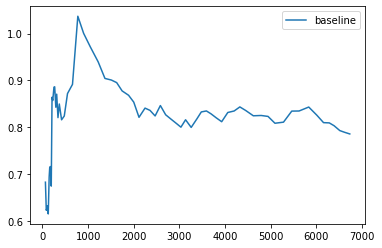

In [28]:
baseline.rename("baseline").plot(legend=True)

In [30]:
proba_table = X_test[["horse_id"]].copy()
proba_table["proba"] = me.predict_proba(X_test)
proba_table["R"] = proba_table.index.map(lambda x: str(x)[-2:])
proba_table.groupby("R")["proba"].mean()

R
01    0.387451
02    0.446652
03    0.469825
04    0.460996
05    0.497705
06    0.487799
07    0.508677
08    0.522680
09    0.564831
10    0.537400
11    0.543513
12    0.499253
Name: proba, dtype: float64

1Rと9Rでは馬の強さに結構な差があることがわかる。

# 2.標準化

## 2.1 transformとapply

In [33]:
proba_table.groupby(level=0)["proba"].apply(np.sum)

201903030101    5.450936
201903030102    5.475330
201903030103    5.034245
201903030104    4.439839
201903030105    8.138268
                  ...   
201909050808    9.511182
201909050809    8.319482
201909050810    7.918869
201909050811    6.401699
201909050812    8.058497
Name: proba, Length: 956, dtype: float64

In [34]:
proba_table.groupby(level=0)["proba"].transform(np.sum)

201906040206    5.074795
201906040206    5.074795
201906040206    5.074795
201906040206    5.074795
201906040206    5.074795
                  ...   
201906050809    9.894587
201906050809    9.894587
201906050809    9.894587
201906050809    9.894587
201906050809    9.894587
Name: proba, Length: 12870, dtype: float64

In [36]:
standard_scaler = lambda x: (x - x.mean()) / x.std()
proba_std = proba_table.groupby(level=0)["proba"].transform(standard_scaler)

<AxesSubplot:>

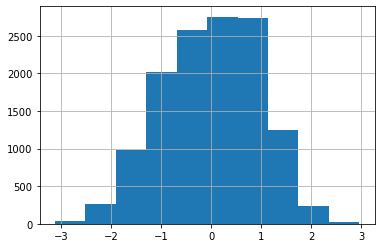

In [37]:
proba_std.hist()

<AxesSubplot:>

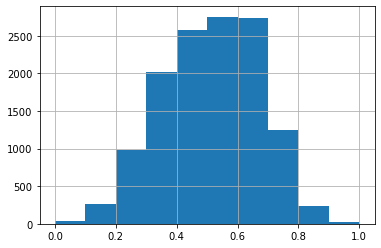

In [38]:
proba_minmax = (proba_std - proba_std.min()) / (proba_std.max() - proba_std.min())
proba_minmax.hist()

## 2.2 回収率(相対評価)

In [46]:
me = ModelEvaluator(lgb_clf, return_tables,std=True)

In [47]:
gain_std = gain(me.tansho_return, X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

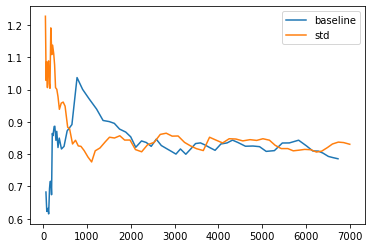

In [48]:
baseline.rename("baseline").plot(legend=True)
gain_std.rename("std").plot(legend=True)

In [49]:
gain_std.max()

1.226923076923077

In [51]:
gain_std[50:]

671    0.831595
603    0.879104
560    0.883214
501    0.948503
457    0.961269
413    0.957869
371    0.938814
339    0.978171
312    1.000641
283    1.006007
262    1.075954
242    1.110331
216    1.137500
198    1.108081
175    1.190857
156    1.003846
141    1.018440
125    1.088800
107    1.083178
98     1.006122
94     1.030851
87     1.064368
77     1.085714
67     1.028358
63     1.093651
52     1.226923
dtype: float64

In [55]:
np.sum(me.predict(X_test,threshold=0.82))

175

In [56]:
me.pred_table(X_test,threshold=0.82)

201906040206    12
201906040203     2
201906040201     5
201906040205     7
201909040208     7
                ..
201909050711    11
201909050709     4
201906050802    14
201906050805     6
201906050804     9
Name: 馬番, Length: 175, dtype: int64

In [58]:
_, sample = split_data(results_m)
bets = sample[["着順", "人気", "単勝", "馬番"]].merge(
    me.pred_table(X_test, threshold=0.82),
    left_index=True,
    right_index=True,
    how="right",
)

In [59]:
bets

,着順,人気,単勝,馬番_x,馬番_y
201903030102,1,4.0,8.0,1,14
201903030102,2,1.0,2.7,14,14
201903030102,3,8.0,17.4,10,14
201903030102,4,6.0,12.3,3,14
201903030102,5,2.0,5.5,9,14
...,...,...,...,...,...
201909050711,14,12.0,83.1,9,11
201909050711,15,17.0,418.1,7,11
201909050711,16,16.0,279.8,13,11
201909050711,17,9.0,35.9,16,11


馬番Xは元々のもので、馬番Yがそのレースでかけた馬の馬番

In [60]:
bets[bets["馬番_x"] == bets["馬番_y"]]["人気"].value_counts()

1.0     86
2.0     41
3.0     16
4.0     12
5.0      6
7.0      5
10.0     2
8.0      2
9.0      2
6.0      2
12.0     1
Name: 人気, dtype: int64

何番人気に賭けた枚数

In [61]:
bets[(bets["馬番_x"]==bets["馬番_y"])&(bets["着順"]==1)]["人気"].value_counts()

1.0    31
2.0    12
3.0     2
4.0     2
7.0     1
9.0     1
5.0     1
Name: 人気, dtype: int64

In [62]:
len(bets[(bets["馬番_x"]==bets["馬番_y"])&(bets["着順"]==1)]["人気"])/len(bets[bets["馬番_x"] == bets["馬番_y"]]["人気"])

0.2857142857142857

In [64]:
rt = Return(return_tables)
bets = rt.tansho.merge(
    me.pred_table(X_test, threshold=0.82),
    left_index=True,
    right_index=True,
    how="right",
)
bets

,win,return,馬番
201903030102,1.0,800.0,14
201904030102,12.0,310.0,13
201904030112,15.0,280.0,15
201904030206,15.0,440.0,1
201904030306,4.0,750.0,6
...,...,...,...
201909050705,2.0,470.0,16
201909050706,12.0,220.0,13
201909050709,4.0,280.0,4
201909050711,5.0,210.0,5


In [66]:
wins=bets[bets["win"]==bets["馬番"]]
wins

,win,return,馬番
201904030112,15.0,280.0,15
201905040105,16.0,1310.0,16
201905040504,5.0,440.0,5
201905040806,16.0,210.0,16
201905040812,13.0,190.0,13
201905050106,12.0,170.0,12
201905050202,14.0,120.0,14
201905050205,1.0,140.0,1
201905050206,4.0,190.0,4
201905050408,14.0,230.0,14


In [67]:
wins["return"].sum()-175*100

3340.0

# 3.スクレイピング

In [70]:
def scrape_race_results(race_id_list, pre_race_results={}):
    race_results = pre_race_results
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            df = pd.read_html(url)[0]

            time.sleep(1)

            # horse_idとjockey_idをスクレイピング
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")
            # horse_id
            horse_id_list = []
            horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                "a", attrs={"href": re.compile("^/horse")}
            )
            for a in horse_a_list:
                horse_id_list.append(re.findall(r"\d+", a["href"])[0])
            # horse_id
            jockey_id_list = []
            jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                "a", attrs={"href": re.compile("^/jockey")}
            )
            for a in jockey_a_list:
                jockey_id_list.append(re.findall(r"\d+", a["href"])[0])

            df["horse_id"] = horse_id_list
            df["jockey_id"] = jockey_id_list

            race_results[race_id] = df
        except IndexError:
            continue
        except Exception as e:
            print(e)
        except:
            break
    return race_results


def scrape_race_info(race_id_list, pre={}):
    race_infos = pre
    for race_id in tqdm(race_id_list):
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = (
                soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
            )
            info = re.findall(r"\w+", texts)
            info_dict = {}
            for text in info:
                if text in ["芝", "ダート"]:
                    info_dict["race_type"] = text
                if "障" in text:
                    info_dict["race_type"] = "障害"
                if "m" in text:
                    info_dict["course_len"] = re.findall(r"\d+", text)[0]
                if text in ["良", "稍重", "重", "不良"]:
                    info_dict["ground_state"] = text
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    info_dict["weather"] = text
                if "年" in text:
                    info_dict["date"] = text
            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
        except:
            break
    return race_infos


def scrape_return_tables(race_id_list, pre_return_tables={}):
    return_tables = pre_return_tables
    for race_id in tqdm(race_id_list):
        if race_id in return_tables.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/race/" + race_id
            f = urlopen(url)
            html = f.read()
            html = html.replace(b"<br />", b"br")
            dfs = pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
        except IndexError:
            continue
        except Exception as e:
            print(e)
        except:
            break
    return return_tables


def scrape_peds(horse_id_list, pre_peds={}):
    peds = pre_peds
    for horse_id in tqdm(horse_id_list):
        if horse_id in peds.keys():
            continue
        try:
            url = "https://db.netkeiba.com/horse/ped/" + horse_id
            df = pd.read_html(url)[0]

            generations = {}
            for i in range(5)[::-1]:
                generations[i] = df[i]
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
            ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)

            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
    return peds


def scrape_horse_results(horse_id_list, pre_horse_results={}):
    horse_results = pre_horse_results
    for horse_id in tqdm(horse_id_list):
        if horse_id in horse_results.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/horse/" + horse_id
            df = pd.read_html(url)[3]
            if df.columns[0] == "受賞歴":
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
        except IndexError:
            continue
        except Exception as e:
            print(e)
        except:
            break
    return horse_results


def scrape_horse_rp(horse_id_list, pre_peds={}, pre_horse_results={}):
    horse_results = pre_horse_results
    peds = pre_peds
    for horse_id in tqdm(horse_id_list):
        if horse_id in horse_results.keys():
            continue
        if horse_id in peds.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/horse/" + horse_id
            df = pd.read_html(url)[3]
            urlp = "https://db.netkeiba.com/horse/ped/" + horse_id
            dfp = pd.read_html(urlp)[0]
            if df.columns[0] == "受賞歴":
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
            generations = {}
            for i in range(5)[::-1]:
                generations[i] = dfp[i]
                dfp.drop([i], axis=1, inplace=True)
                dfp = dfp.drop_duplicates()
            ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)

        except IndexError:
            continue
        except Exception as e:
            print(e)
        except:
            break
    return horse_results, peds

In [65]:
race_id_list = []
for place in range(1, 11):
    for kai in range(1, 6):
        for day in range(1, 13): #9->13
            for race in range(1, 13):
                race_id = (
                    "2020"
                    + str(place).zfill(2)
                    + str(kai).zfill(2)
                    + str(day).zfill(2)
                    + str(race).zfill(2)
                )
                race_id_list.append(race_id)

# 4.出馬表データ

In [132]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame()
        self.data_p = pd.DataFrame()
        self.data_h = pd.DataFrame()
        self.data_pe = pd.DataFrame()
        self.data_c = pd.DataFrame()

    def merge_horse_results(self, hr, n_samples_list=[5, 9, "all"]):
        self.data_h = self.data_p.copy()
        for n in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n)

    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(
            peds, left_on="horse_id", right_index=True, how="left"
        )
        self.no_peds = self.data_pe[self.data_pe["peds_0"].isnull()][
            "horse_id"
        ].unique()
        if len(self.no_peds) > 0:
            print("後でスクレイピング")

    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        mask_horse = df["horse_id"].isin(le_horse.classes_)
        new_horse_id = df["horse_id"].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df["horse_id"] = le_horse.transform(df["horse_id"])

        mask_jockey = df["jockey_id"].isin(le_jockey.classes_)
        new_jockey_id = df["jockey_id"].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df["jockey_id"] = le_jockey.transform(df["jockey_id"])

        df["horse_id"] = df["horse_id"].astype("category")
        df["jockey_id"] = df["jockey_id"].astype("category")

        weathers = results_m["weather"].unique()
        race_types = results_m["race_type"].unique()
        ground_states = results_m["ground_state"].unique()
        sexes = results_m["性"].unique()
        df["weather"] = pd.Categorical(df["weather"], weathers)
        df["race_type"] = pd.Categorical(df["race_type"], race_types)
        df["ground_state"] = pd.Categorical(df["ground_state"], ground_states)
        df["性"] = pd.Categorical(df["性"], sexes)
        df = pd.get_dummies(df, columns=["weather", "race_type", "ground_state", "性"])

        self.data_c = df


class ShutubaTable(DataProcessor):
    def __init__(self):
        super(ShutubaTable, self).__init__()

    def scrape(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = "https://race.netkeiba.com/race/shutuba.html?race_id=" + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = soup.find("div", attrs={"class": "RaceData01"}).text
            texts = re.findall(r"\w+", texts)
            for text in texts:
                if "m" in text:
                    df["corse_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "重"]:
                    df["ground_state"] = [text] * len(df)
                if text in "不":
                    df["ground_state"] = ["不良"] * len(df)
                if "芝" in text:
                    df["race_type"] = ["芝"] * len(df)
                if "ダ" in text:
                    df["race_type"] = ["ダート"] * len(df)
                if "障" in text:
                    df["race_type"] = ["障害"] * len(df)
            df["date"] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={"class": "HorseInfo"})
            for td in horse_td_list:
                horse_id = re.findall(r"\d+", td.find("a")["href"])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={"class": "Jockey"})
            for td in jockey_td_list:
                jockey_id = re.findall(r"\d+", td.find("a")["href"])[0]
                jockey_id_list.append(jockey_id)

            df["horse_id"] = horse_id_list
            df["jockey_id"] = jockey_id_list

            df.index = [race_id] * len(df)
            self.data = self.data.append(df)
            time.sleep(1)

    def preprocessing(self, flag=False):#馬体重を除く
        df = self.data.copy()
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        if flag:
            df.drop(["馬体重(増減)"], axis=1, inplace=True)
        else:
            df = df[df["馬体重(増減)"] != "--"]
            df = df[~df["馬体重(増減)"].isnull()]
            # 馬体重を体重と体重変化に分ける
            df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)
            df["体重変化"] = (
                df["馬体重(増減)"].str.split("(", expand=True)[1].str[:-1].astype(int)
            )

        df["date"] = pd.to_datetime(df["date"])
        df["枠"] = df["枠"].astype(int)
        df["馬番"] = df["馬番"].astype(int)
        df["斤量"] = df["斤量"].astype(int)
        df_list = [
            "枠",
            "馬番",
            "斤量",
            "corse_len",
            "weather",
            "race_type",
            "ground_state",
            "date",
            "horse_id",
            "jockey_id",
            "性",
            "年齢",
        ]
        if not flag:
            df_list.append("体重")
            df_list.append("体重変化")
        # 不要な列を削除
        df = df[df_list]
        self.data_p = df.rename(columns={"枠": "枠番"})


class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results

    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df = df[~(df["着順"].astype(str).str.contains("\D"))]
        df["着順"] = df["着順"].astype(int)
        df["rank"] = df["着順"].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df["単勝"] = df["単勝"].astype(float)

        # 不要な列を削除
        df.drop(
            ["タイム", "着差", "調教師", "性齢", "馬体重", "馬名", "騎手", "着順", "単勝", "人気"],
            axis=1,
            inplace=True,
        )

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")

        self.data_p = df

    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe["horse_id"])
        self.le_jockey = LabelEncoder().fit(self.data_pe["jockey_id"])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

In [52]:
target_rid=input()[:-2] #予想するレース
rid=[target_rid+"{}".format(str(i).zfill(2)) for i in range(1,13)] 

 202105030211


In [180]:
st=ShutubaTable()
target_date=input("format:oooo/oo/oo")
st.scrape(rid,target_date)

format:oooo/oo/oo 2021/06/06


  0%|          | 0/12 [00:00<?, ?it/s]

In [181]:
st.preprocessing(flag=True)

In [182]:
st.merge_horse_results(hr)
#st.data_h.head()a

In [183]:
st.merge_peds(p.peds_e)
#st.data_pe

aaaaaaaaaaaaaaa


In [137]:
#st.shutuba_tables_pe[st.shutuba_tables_pe["peds_0"].isnull()]

## 4.1 ラベルエンコーディング、ダミー変数化

In [138]:
#le_jockey=LabelEncoder().fit(results_m["jockey_id"])
#le_horse=LabelEncoder().fit(results_m["horse_id"])

In [139]:
r=Results(results_n) 
r.preprocessing()
#r.data_p.head()

In [140]:
r.merge_horse_results(hr) #about 2~3minutes
#r.data_h.head()

In [141]:
r.merge_peds(p.peds_e)
#r.data_pe.head()

In [142]:
r.process_categorical()
#r.data_c.head()

In [184]:
st.process_categorical(r.le_horse,r.le_jockey,r.data_pe)
#st.data_c.head()

## 4.2 実際に勝率を予測

In [185]:
flag=True if input("y or n")=="y" else False
X=r.data_c.drop(["rank","date"],axis=1)
if flag:
    X.drop(["体重","体重変化"],axis=1,inplace=True)
y=r.data_c["rank"]

y or n y


In [186]:
params = {
    "num_leaves": 4,
    "n_estimators": 80,
    "class_weight": "balanced",
    "random_state": 100,
}
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X.values, y.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [187]:
me=ModelEvaluator(lgb_clf,return_tables)
pred=me.predict_proba(st.data_c.drop(["date"],axis=1))

In [173]:
pred_rec=me.predict(st.data_c.drop(["date"],axis=1),0.82)

In [188]:
R_index=input()
pred_table=st.data_c[["馬番"]].copy()
pred_table["pred"]=pred
pred_table.sort_values("pred",ascending=False).loc[target_rid+R_index]

 11


,馬番,pred
202105030211,13,0.896615
202105030211,1,0.834473
202105030211,5,0.811236
202105030211,8,0.791482
202105030211,11,0.737641
202105030211,12,0.689991
202105030211,14,0.663248
202105030211,4,0.639552
202105030211,6,0.639458
202105030211,7,0.420900
